In [1]:
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from keras import layers

print(keras.__version__)
print(keras.backend.backend())

3.3.3
tensorflow


## Read Data

In [3]:
import os


EPOCHS = 10000
# C_TYPE = "tot"  # either tot or diss
# MODE = "pos"  # either neg or pos
C_TYPE = os.environ['C_TYPE']  # either tot or diss
MODE = os.environ['C_MODE']  # either neg or pos

SAVE_DATA = True
print("="*100)
print(C_TYPE, MODE)

tot pos


In [4]:

@dataclass
class ProgramOptions:
    x_train: Path
    y_train: Path
    x_test: Path
    output_dir: Path


base_dir = Path("../data_out/default_finn").resolve()
base_input_dir = base_dir / "residual_training_data"
args = ProgramOptions(
    x_train=base_input_dir / f"X_{MODE}_train_{C_TYPE}.npy",
    y_train=base_input_dir / f"Y_{MODE}_train_{C_TYPE}.npy",
    x_test=base_input_dir / f"X_{MODE}_test_{C_TYPE}.npy",
    output_dir=base_dir / "residual_nets_output",
)
args.output_dir.mkdir(parents=True, exist_ok=True)

# Load data
x_train = np.load(args.x_train).astype("float32")
y_train = np.load(args.y_train).astype("float32")
x_test = np.load(args.x_test).astype("float32")

# check that y_train is either fully positive or negative
if np.all(y_train >= 0):
    data_sign = 1
elif np.all(y_train <= 0):
    data_sign = -1
else:
    raise ValueError("y_train must be either fully positive or negative.")

# Reshape y_train if it's a 1D array
if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)

In [5]:
# --- Transform data ---
T_MAX = 251  # FIXME: This is not good. Only works if we have 51 time steps?
y_scaler = MinMaxScaler()

# make data positive
# This should happen before the minmax scaler because it will just shift the values to 0 and scale them to 1 but then negative values close to zero will be positive but close to 1 after the transformation which is not what I want.
y_train *= data_sign

x_test[:, 0] /= T_MAX
x_train[:, 0] /= T_MAX
y_train = y_scaler.fit_transform(y_train)

print(
    f"X Train: {x_train.min():.1f}, {x_train.max():.1f}, {x_train.mean():.1f}, {x_train.std():.1f}"
)
print(
    f"X Test: {x_test.min():.1f}, {x_test.max():.1f}, {x_test.mean():.1f}, {x_test.std():.1f}"
)
print(
    f"Y Train: {y_train.min():.1f}, {y_train.max():.1f}, {y_train.mean():.1f}, {y_train.std():.1f}"
)

X Train: 0.0, 1.0, 0.5, 0.3
X Test: 0.0, 1.0, 0.5, 0.3
Y Train: 0.0, 1.0, 0.1, 0.1


## Visualize Training Data

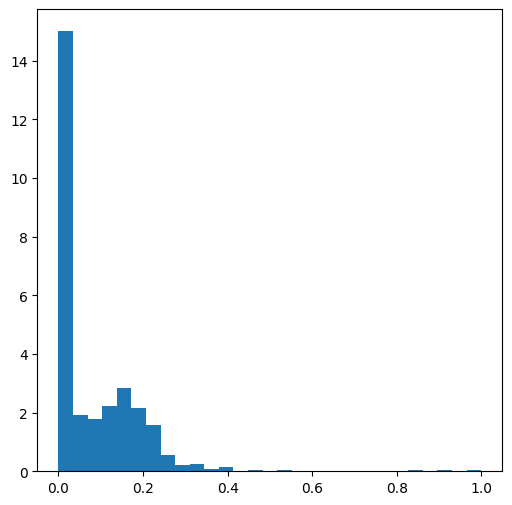

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(y_train, bins="auto", density=True)
if SAVE_DATA:
    fig.savefig(args.output_dir / f"y_train_{MODE}_{C_TYPE}_hist.png")

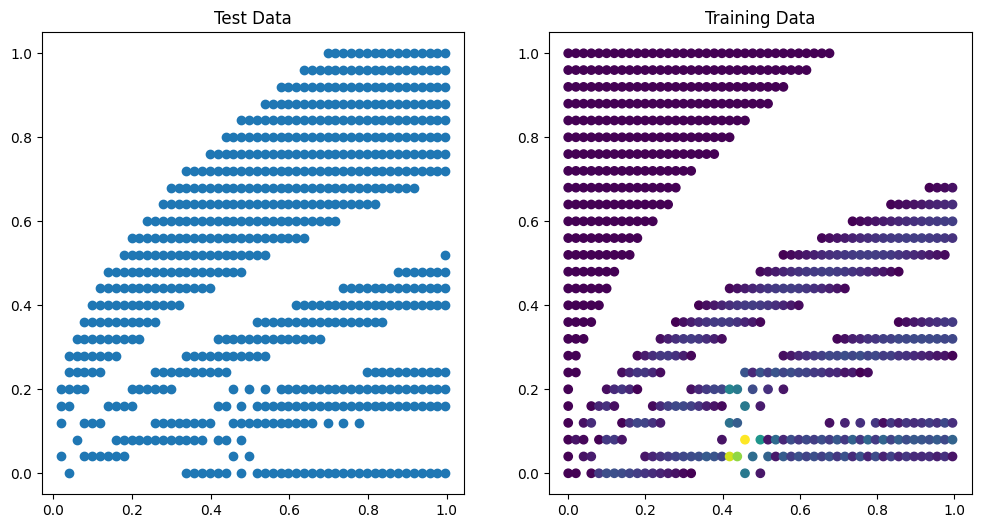

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.scatter(x_test[:, 0], x_test[:, 1])
ax1.set_title("Test Data")

ax2.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="viridis")
ax2.set_title("Training Data")

if SAVE_DATA:
    fig.savefig(args.output_dir / f"x_data_{MODE}_{C_TYPE}.png")

## Initialize Model

In [12]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]

model = keras.Sequential(
    [
        layers.Input(shape=(input_size,)),
        # layers.Dense(2048, activation="relu"),
        
        # l2: 1e-2 is too large
        # l2: 1e-4 is a bit too small
        # l2: 1e-3 is a bit too small
        # l2: 5e-3 is good
        # l1: 5e-3 is too large
        # l1: 1e-4 is a tiny bit too small
        # l1: 1e-3 is too large
        layers.Dense(2048, activation="relu", kernel_regularizer=keras.regularizers.l1(1e-4)),
        # layers.Dense(output_size, activation="sigmoid"),
        layers.Dense(output_size),
    ]
)

model.compile(loss="mse", optimizer="adam")

## Train Model

In [13]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=len(x_train), verbose=0)

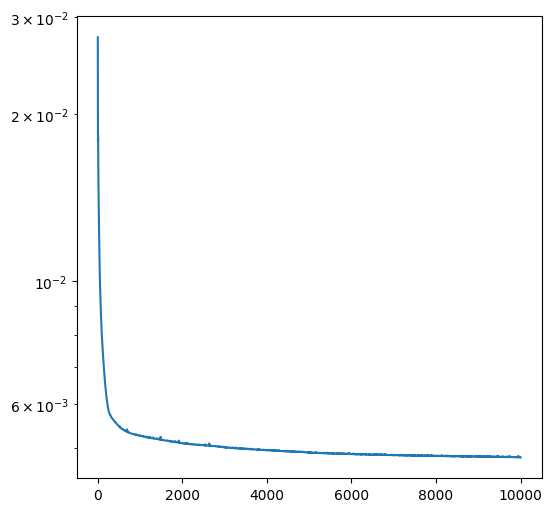

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.semilogy(history.history["loss"])
if SAVE_DATA:
    fig.savefig(args.output_dir / f"loss_{MODE}_{C_TYPE}.png")

## Analyze Results

In [15]:
# Evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Generate predictions for plotting
t_range = np.linspace(0.0, 1.0, 51)
x_range = np.linspace(0.0, 1.0, 26)
X, T = np.meshgrid(x_range, t_range)
X_full = np.c_[T.ravel(), X.ravel()]

Train Loss: 0.0048


In [16]:
X_full[:10]

array([[0.  , 0.  ],
       [0.  , 0.04],
       [0.  , 0.08],
       [0.  , 0.12],
       [0.  , 0.16],
       [0.  , 0.2 ],
       [0.  , 0.24],
       [0.  , 0.28],
       [0.  , 0.32],
       [0.  , 0.36]])

In [17]:
y_pred_full = model.predict(X_full)
y_pred_test = model.predict(x_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step


In [18]:
y_pred_full = y_scaler.inverse_transform(y_pred_full)
y_pred_full *= data_sign
y_pred_test = y_scaler.inverse_transform(y_pred_test)
y_pred_test *= data_sign
y_train = y_scaler.inverse_transform(y_train)
y_train *= data_sign

print(y_pred_full.max(), y_pred_full.min())
print(y_pred_test.max(), y_pred_test.min())

# check that y_pred_full is either fully positive or negative
# assert np.all(y_pred_full >= 0) or np.all(y_pred_full <= 0)

0.0002840522 -1.6304011e-05
0.00028512944 -1.6090064e-05


In [19]:
x_train_plus_test = np.concatenate([x_train, x_test])
y_train_plus_pred_test = np.concatenate([y_train, y_pred_test])

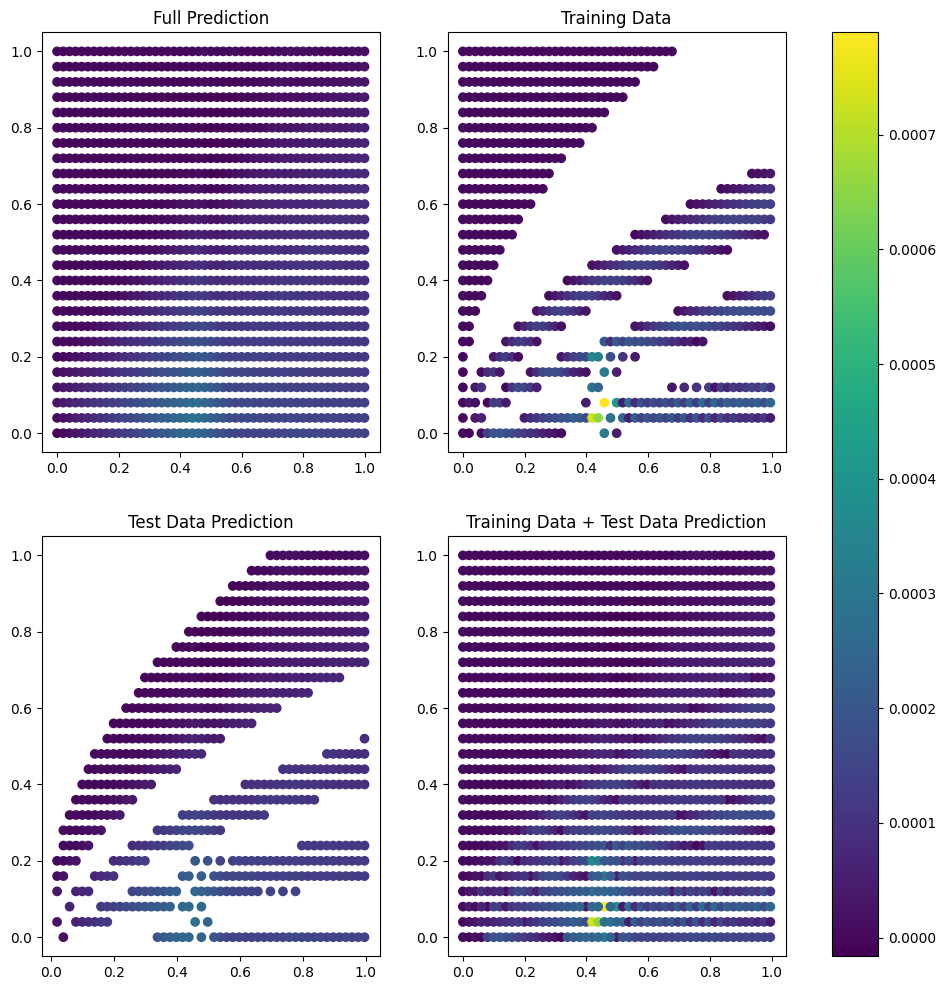

In [20]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Get min and max values for consistent color mapping
vmin = min(
    y_pred_full.min(), y_train.min(), y_pred_test.min(), y_train_plus_pred_test.min()
)
vmax = max(
    y_pred_full.max(), y_train.max(), y_pred_test.max(), y_train_plus_pred_test.max()
)

# Create a Normalize object
norm = Normalize(vmin=vmin, vmax=vmax)

# Create a ScalarMappable object for the colorbar
sm = ScalarMappable(norm=norm, cmap=plt.get_cmap("viridis"))
# You can choose a different colormap if desired

# Plot the model's predictions
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs[0, 0].set_title("Full Prediction")
axs[0, 0].scatter(*X_full.T, c=sm.to_rgba(y_pred_full))

axs[0, 1].set_title("Training Data")
axs[0, 1].scatter(*x_train.T, c=sm.to_rgba(y_train))

axs[1, 0].set_title("Test Data Prediction")
axs[1, 0].scatter(*x_test.T, c=sm.to_rgba(y_pred_test))

axs[1, 1].set_title("Training Data + Test Data Prediction")
axs[1, 1].scatter(*x_train_plus_test.T, c=sm.to_rgba(y_train_plus_pred_test))

# Add a colorbar to the figure
fig.colorbar(sm, ax=axs.ravel().tolist())
fig.savefig(args.output_dir / f"predictions_{MODE}_{C_TYPE}.png")

In [21]:
if SAVE_DATA:
    np.save(args.output_dir / f"predictions_{MODE}_{C_TYPE}.npy", y_pred_full)

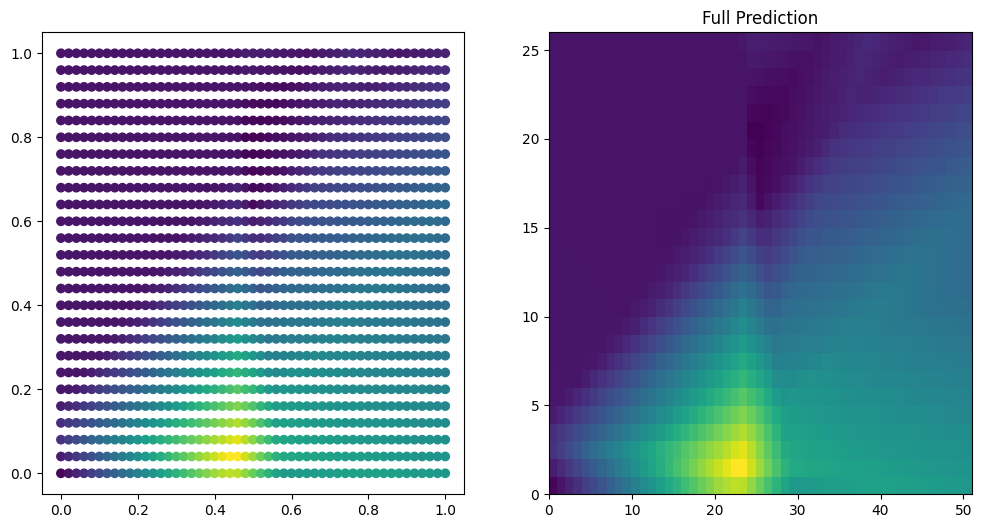

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plt.title("Full Prediction")
axs[0].scatter(*X_full.T, c=y_pred_full)
axs[1].pcolor(y_pred_full.reshape(51, 26).T)